In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from io import open
from collections import Counter
from functools import partial
import unicodedata
import re
from torch.autograd import Variable
from gensim.models import KeyedVectors
import sacrebleu
import random
import time
from datetime import datetime
import pickle as pkl
import string
import os
from os import listdir 
from ast import literal_eval
from sklearn.metrics import confusion_matrix
import matplotlib.style
import matplotlib as mpl

pd.set_option('max_colwidth',100)
mpl.style.use('bmh')
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Process Data

In [2]:
RESERVED_TOKENS = {'<SOS>': 0, '<EOS>': 1, '<PAD>': 2, '<UNK>': 3}

In [3]:
def text2tokens(raw_text_fp, lang_type): 
    """ Takes filepath to raw text and outputs a list of lists, each representing a sentence of words (tokens) """
    with open(raw_text_fp) as f:
        tokens_data = [line.lower().split() for line in f.readlines()]
        if lang_type == 'source': 
            tokens_data = [datum + ['<EOS>'] for datum in tokens_data]
        elif lang_type == 'target': 
            tokens_data = [['<SOS>'] + datum + ['<EOS>'] for datum in tokens_data]
    return tokens_data 

def load_word2vec(lang): 
    """ Loads pretrained vectors for a given language """
    filepath = "data/pretrained_word2vec/wiki.zh.vec".format(lang)
    word2vec = KeyedVectors.load_word2vec_format(filepath)
    return word2vec

def build_vocab(token_lists, max_vocab_size, word2vec): 
    """ Takes lists of tokens (representing sentences of words), max_vocab_size, word2vec model and returns: 
        - id2token: list of tokens, where id2token[i] returns token that corresponds to i-th token 
        - token2id: dictionary where keys represent tokens and corresponding values represent their indices
        Note that the vocab will comprise N=max_vocab_size-len(RESERVED_TOKENS) tokens that are in word2vec model 
    """
    num_vocab = max_vocab_size - len(RESERVED_TOKENS)
    all_tokens = [token for sublist in token_lists for token in sublist]
    token_counter = Counter(all_tokens)
    token_counter_filtered = Counter({token: token_counter[token] for token in token_counter if token in word2vec})
    vocab, count = zip(*token_counter_filtered.most_common(num_vocab))
    id2token = list(RESERVED_TOKENS.keys()) + list(vocab)
    token2id = dict(zip(id2token, range(max_vocab_size)))
    return token2id, id2token 

def tokens2indices(tokens_data, token2id): 
    """ Takes tokenized data and token2id dictionary and returns indexed data """
    indices_data = [] 
    for datum in tokens_data: 
        indices_datum = [token2id[token] if token in token2id else RESERVED_TOKENS['<UNK>'] for token in datum ]
        indices_data.append(indices_datum)    
    return indices_data

def get_filepath(split, src_lang, targ_lang, lang_type): 
    """ Locates data filepath given data split type (train/dev/test), translation pairs (src_lang -> targ_lang), 
        and the language type (source or target)
    """
    folder_name = "data/iwslt-{}-{}/".format(src_lang, targ_lang)
    if lang_type == 'source': 
        file_name = "{}.tok.{}".format(split, src_lang)
    elif lang_type == 'target': 
        file_name = "{}.tok.{}".format(split, targ_lang)
    return folder_name + file_name 

def get_filepaths(src_lang, targ_lang): 
    """ Takes language names to be translated from and to (in_lang and out_lang respectively) as inputs, 
        returns a nested dictionary containing the filepaths for input/output data for train/dev/test sets  
    """
    fps = {} 
    
    # store language names 
    fps['languages'] = {} 
    fps['languages']['source'] = src_lang
    fps['languages']['target'] = targ_lang 
    
    # store filepaths 
    for split in ['train', 'dev', 'test']: 
        fps[split] = {} 
        for lang_type in ['source', 'target']: 
            fps[split][lang_type] = {} 
            fps[split][lang_type]['filepath'] = get_filepath(split, src_lang, targ_lang, lang_type)
            
    return fps 

In [4]:
SRC_LANG = 'zh'
TARG_LANG = 'en'

### Define Vocab 

In [5]:
SRC_VOCAB_SIZE = 10000
TARG_VOCAB_SIZE = 10000
# ENC_EMBED_DIM = 300 
# DEC_EMBED_DIM = 300

In [6]:
# generate language dictionaries from train sets 

def generate_vocab(src_lang, targ_lang, src_vocab_size, targ_vocab_size):
    """ Outputs a nested dictionary containing token2id, id2token, and word embeddings 
    for source and target lang's vocab """
    
    vocab = {} 
    for lang, vocab_size in zip([src_lang, targ_lang], [src_vocab_size, targ_vocab_size]): 
        
        # load train data 
        train_data_fp = get_filepath(split='train', src_lang=SRC_LANG, targ_lang=TARG_LANG, 
                                     lang_type='target' if lang == 'en' else 'source')
        with open(train_data_fp) as f:
            train_tokens = [line.lower().split() for line in f.readlines()]        
        
        # load word embeddings, generate token2id and id2token 
        word2vec_full = load_word2vec(lang)
        token2id, id2token = build_vocab(train_tokens, vocab_size, word2vec_full) 
        word2vec_reduced = {word: word2vec_full[word] for word in token2id if word not in RESERVED_TOKENS} 
        
        # store token2id, id2token, and word embeddings as a dict in nested dict lang 
        vocab[lang] = {'token2id': token2id, 'id2token': id2token, 'word2vec': word2vec_reduced}
        
    return vocab 

In [7]:
vocab = generate_vocab(SRC_LANG, TARG_LANG, SRC_VOCAB_SIZE, TARG_VOCAB_SIZE)

### Create Data Loaders 

In [55]:
# new process_data that uses separate generate_vocab function 

# def process_data(src_lang, targ_lang): 
#     """ Takes source language and target language names and respective max vocab sizes as inputs 
#         and returns as a nested dictionary containing: 
#         - train_indices, val_indices, test_indices (as lists of source-target tuples)
#         - train_tokens, val_tokens, test_tokens (as lists of source-target tuples)
#         - source language's token2id and id2token 
#         - target language's token2id and id2token
#     """
    
#     # get filepaths 
#     data = get_filepaths(src_lang, targ_lang)
    
#     # loop through each file, read in text, convert to tokens, then to indices 
#     for split in ['train', 'dev', 'test']: 
#         for lang_type in ['source', 'target']: 
#             # read in tokens 
#             data[split][lang_type]['tokens'] = text2tokens(data[split][lang_type]['filepath'], lang_type)
#             # convert tokens to indices 
#             data[split][lang_type]['indices'] = tokens2indices(
#                 data[split][lang_type]['tokens'], vocab[data['languages'][lang_type]]['token2id'])
        
#     return data

def process_data(src_lang, targ_lang, sample_limit=None): 
    """ Takes source language and target language names and respective max vocab sizes as inputs 
        and returns as a nested dictionary containing: 
        - train_indices, val_indices, test_indices (as lists of source-target tuples)
        - train_tokens, val_tokens, test_tokens (as lists of source-target tuples)
        - source language's token2id and id2token 
        - target language's token2id and id2token
    """
    
    # get filepaths 
    data = get_filepaths(src_lang, targ_lang)
    
    # loop through each file, read in text, convert to tokens, then to indices 
    for split in ['train', 'dev', 'test']: 
        for lang_type in ['source', 'target']: 
            # read in tokens 
            tokens = text2tokens(data[split][lang_type]['filepath'], lang_type)
            if sample_limit is not None: 
                tokens = tokens[:sample_limit]
            # convert tokens to indices 
            indices = tokens2indices(tokens, vocab[data['languages'][lang_type]]['token2id'])
            # save to dictionary 
            data[split][lang_type]['tokens'] = tokens
            data[split][lang_type]['indices'] = indices
            
    return data

In [9]:
data = process_data(SRC_LANG, TARG_LANG)

In [10]:
# print example for sanity check  
print("Example Source: {}".format(data['train']['source']['tokens'][5]))
print("Example Target: {}".format(data['train']['target']['tokens'][5]))

Example Source: ['泰坦', '泰坦尼克', '泰坦尼克号', '坦尼', '尼克', '号', '是', '拿', '了', '不少', '票房', '冠军', '但', '事实', '事实上', '它', '并', '不是', '关于', '于海洋', '海洋', '的', '最', '刺激', '的', '故事', '<EOS>']
Example Target: ['<SOS>', 'the', 'truth', 'of', 'the', 'matter', 'is', 'that', 'the', 'titanic', '--', 'even', 'though', 'it', '&apos;s', 'breaking', 'all', 'sorts', 'of', 'box', 'office', 'records', '--', 'it', '&apos;s', 'not', 'the', 'most', 'exciting', 'story', 'from', 'the', 'sea', '.', '<EOS>']


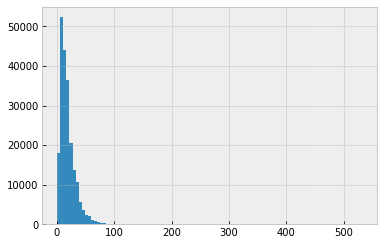

In [11]:
# check distribution of source sentence lengths 
pd.Series(np.array([len(l) for l in data['train']['source']['indices']])).hist(bins=100);

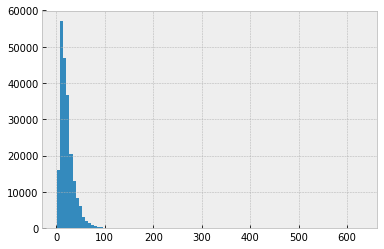

In [12]:
# check distribution of target sentence lengths 
pd.Series(np.array([len(l) for l in data['train']['target']['indices']])).hist(bins=100); 

# Create Data Loaders

In [40]:
class TranslationDataset(Dataset): 
    """ 
    Class that represents a train/validation/test/dataset that's readable for Pytorch. 
    Note that this class inherits torch.utils.data.Dataset
    """
    def __init__(self, src_indices, targ_indices, src_max_sentence_len, targ_max_sentence_len):
        """ 
        Initialize dataset by passing in a list of input indices and a list of output indices 
        """
        self.src_indices = src_indices
        self.targ_indices = targ_indices
        self.src_max_sentence_len = src_max_sentence_len
        self.targ_max_sentence_len = targ_max_sentence_len
        assert (len(self.src_indices) == len(self.targ_indices))
        
    def __len__(self): 
        return len(self.src_indices)
    
    def __getitem__(self, key): 
        """ 
        Triggered when dataset[i] is called, outputs lists of input and output indices, as well as their 
        respective lengths
        """
        src_idx = self.src_indices[key][:self.src_max_sentence_len]
        src_len = len(src_idx)
        targ_idx = self.targ_indices[key][:self.targ_max_sentence_len]
        targ_len = len(targ_idx)
        return [src_idx, targ_idx, src_len, targ_len]
    
def collate_func(src_max_sentence_len, targ_max_sentence_len, batch): 
    """ Customized function for DataLoader that dynamically pads the batch so that all data have the same length"""
    
    src_idxs = [] 
    targ_idxs = [] 
    src_lens = [] 
    targ_lens = [] 
    
    for datum in batch: 
        # append original lengths of sequences 
        src_lens.append(datum[2]) 
        targ_lens.append(datum[3])
        
        # pad sequences before appending 
        src_idx_padded = np.pad(array=np.array(datum[0]), pad_width = ((0, src_max_sentence_len - datum[2])), 
                                mode='constant', constant_values=RESERVED_TOKENS['<PAD>'])
        targ_idx_padded = np.pad(array=np.array(datum[1]), pad_width = ((0, targ_max_sentence_len - datum[3])),
                                 mode='constant', constant_values=RESERVED_TOKENS['<PAD>'])
        src_idxs.append(src_idx_padded)
        targ_idxs.append(targ_idx_padded)
    
    return [torch.from_numpy(np.array(src_idxs)), torch.from_numpy(np.array(targ_idxs)), 
            torch.LongTensor(src_lens), torch.LongTensor(targ_lens)]

def create_dataloaders(processed_data, src_max_sentence_len, targ_max_sentence_len, batch_size): 
    """ Takes processed_data as dictionary output from process_data func, maximum sentence lengths, 
        and outputs train_loader, dev_loader, and test_loaders 
    """
    loaders = {} 
    for split in ['train', 'dev', 'test']: 
        dataset = TranslationDataset(processed_data[split]['source']['indices'], processed_data[split]['target']['indices'], 
                                     src_max_sentence_len, targ_max_sentence_len)
        loaders[split] = DataLoader(dataset, batch_size=batch_size, shuffle=False, 
                                    collate_fn=partial(collate_func, src_max_sentence_len, targ_max_sentence_len))
    return loaders['train'], loaders['dev'], loaders['test']

In [15]:
BATCH_SIZE = 32
SRC_MAX_SENTENCE_LEN = 40 
TARG_MAX_SENTENCE_LEN = 40

In [41]:
train_loader, dev_loader, test_loader = create_dataloaders(
    data, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
train_loader_limited, dev_loader_limited, test_loader_limited = create_dataloaders(
    limited_data, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)

In [43]:
# check that loader works 
for i, (src_idxs, targ_idxs, src_lens, targ_lens) in enumerate(train_loader):
    print(i)
    print(src_idxs.size())
    print(src_idxs)
    print(src_lens)
    print(targ_idxs.size())
    print(targ_idxs)
    print(targ_lens)
    break 

0
torch.Size([32, 40])
tensor([[3318, 3071,    4,  ...,    2,    2,    2],
        [1606,    3,  124,  ...,    3,    3, 1460],
        [1606,    3, 1106,  ...,    2,    2,    2],
        ...,
        [  11,    6,   86,  ...,    2,    2,    2],
        [ 242,   65,   22,  ...,    2,    2,    2],
        [ 119, 1540,    4,  ...,    2,    2,    2]])
tensor([ 7, 40, 11, 13, 18, 27, 12, 11,  9,  8, 40, 12, 12, 19, 15, 24, 23, 14,
        23, 23, 35,  5, 11,  9,  8,  9,  6, 13,  9,  7, 21, 18])
torch.Size([32, 40])
tensor([[   0,  118,   13,  ...,    2,    2,    2],
        [   0,   28, 7488,  ..., 6098,    4,   86],
        [   0,   18,   17,  ...,    2,    2,    2],
        ...,
        [   0,   14,    3,  ...,    2,    2,    2],
        [   0,   48,   23,  ...,    2,    2,    2],
        [   0,    7,   14,  ...,    2,    2,    2]])
tensor([ 7, 40, 12, 18, 31, 35, 18, 17, 10, 10, 40, 17, 11, 20, 23, 26, 29, 17,
        28, 27, 40,  7, 19, 14, 11, 10,  9, 19, 13,  8, 15, 25])


# Model Architecture

In [44]:
def get_pretrained_emb(word2vec, token2id): 
    """ Given word2vec model and the vocab's token2id, extract pretrained word embeddings """
    pretrained_emb = np.zeros((len(token2id), 300)) 
    for token in token2id: 
        try: 
            pretrained_emb[token2id[token]] = word2vec[token]
        except: 
            pretrained_emb[token2id[token]] = np.random.normal(size=(300,))
    return torch.from_numpy(pretrained_emb.astype(np.float32)).to(device)

In [45]:
class EncoderRNN(nn.Module):
    
    def __init__(self, enc_hidden_dim, num_layers, pretrained_word2vec): 
        super(EncoderRNN, self).__init__()
        self.enc_embed_dim = 300
        self.enc_hidden_dim = enc_hidden_dim 
        self.num_layers = num_layers
        self.embedding = nn.Embedding.from_pretrained(pretrained_word2vec, freeze=True)
        self.gru = nn.GRU(input_size=self.enc_embed_dim, hidden_size=self.enc_hidden_dim, num_layers=self.num_layers, 
                          batch_first=True, bidirectional=True)
    
    def forward(self, enc_input, enc_input_lens):
        batch_size = enc_input.size()[0]
        _, idx_sort = torch.sort(enc_input_lens, dim=0, descending=True)
        _, idx_unsort = torch.sort(idx_sort, dim=0)
        enc_input, enc_input_lens = enc_input.index_select(0, idx_sort), enc_input_lens.index_select(0, idx_sort)
        embedded = self.embedding(enc_input)
        embedded = torch.nn.utils.rnn.pack_padded_sequence(embedded, enc_input_lens, batch_first=True)
        hidden = self.initHidden(batch_size).to(device)
        output, hidden = self.gru(embedded, hidden)
        output, _ = torch.nn.utils.rnn.pad_packed_sequence(output, batch_first=True, 
                                                           total_length=SRC_MAX_SENTENCE_LEN,
                                                           padding_value=RESERVED_TOKENS['<PAD>'])
        output = output.index_select(0, idx_unsort)
        hidden = hidden.index_select(1, idx_unsort).transpose(0, 1).contiguous().view(self.num_layers, batch_size, -1)
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(2*self.num_layers, batch_size, self.enc_hidden_dim, device=device)
    
class DecoderRNN(nn.Module):

    def __init__(self, dec_hidden_dim, enc_hidden_dim, num_layers, pretrained_word2vec):
        super(DecoderRNN, self).__init__()
        self.dec_embed_dim = 300
        self.dec_hidden_dim = dec_hidden_dim 
        self.enc_hidden_dim = enc_hidden_dim
        self.num_layers = num_layers
        self.embedding = nn.Embedding.from_pretrained(pretrained_word2vec, freeze=True)
        self.gru = nn.GRU(self.dec_embed_dim + 2 * self.enc_hidden_dim, self.dec_hidden_dim, num_layers=self.num_layers)
        self.out = nn.Linear(dec_hidden_dim, TARG_VOCAB_SIZE)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, dec_input, dec_hidden, enc_outputs): 
        batch_size = dec_input.size()[0]
        embedded = self.embedding(dec_input).view(1, batch_size, -1)
        context = torch.cat([enc_outputs[:, -1, :self.enc_hidden_dim], 
                             enc_outputs[:, 0, self.enc_hidden_dim:]], dim=1).unsqueeze(0)
        concat = torch.cat([embedded, context], 2)
        output, hidden = self.gru(concat, dec_hidden)
        output = self.softmax(self.out(output[0]))    
        return output, hidden
        
class EncoderDecoder(nn.Module): 
    
    def __init__(self, encoder, decoder, decoder_token2id): 
        super(EncoderDecoder, self).__init__() 
        self.encoder = encoder 
        self.decoder = decoder 

    def forward(self, src_idx, targ_idx, src_lens, targ_lens, teacher_forcing_ratio): 
        batch_size = src_idx.size()[0]
        enc_outputs, enc_hidden = self.encoder(src_idx, src_lens)
        dec_hidden = enc_hidden 
        dec_outputs = Variable(torch.zeros(TARG_MAX_SENTENCE_LEN, batch_size, TARG_VOCAB_SIZE))
        hypotheses = Variable(torch.zeros(TARG_MAX_SENTENCE_LEN, batch_size))
        dec_output = targ_idx[:, 0] # initialize with <SOS>
        for di in range(1, TARG_MAX_SENTENCE_LEN): 
            dec_output, dec_hidden = self.decoder(dec_output, dec_hidden, enc_outputs)
            dec_outputs[di] = dec_output 
            teacher_labels = targ_idx[:, di-1] 
            greedy_labels = dec_output.data.max(1)[1]
            dec_output = teacher_labels if random.random() < teacher_forcing_ratio else greedy_labels 
            hypotheses[di] = greedy_labels

        return dec_outputs, hypotheses.transpose(0,1)
    
class Attention(nn.Module): 
    
    """ Implements the attention mechanism by Bahdanau et al. (2015) """
    
    def __init__(self, enc_hidden_dim, dec_hidden_dim, num_annotations, num_layers): 
        super(Attention, self).__init__() 
        self.num_annotations = num_annotations
        self.input_dim = enc_hidden_dim * 2 + dec_hidden_dim
        self.attn = nn.Linear(self.input_dim, self.num_annotations)
        self.v = nn.Parameter(torch.rand(self.num_annotations))
        self.num_layers = num_layers 
        nn.init.normal_(self.v)
        
    def forward(self, encoder_outputs, last_dec_hidden): 
        batch_size = encoder_outputs.size()[0]
        last_dec_hidden = last_dec_hidden.transpose(0, 1)[:, -1, :].unsqueeze(1) 
        hidden_broadcast = last_dec_hidden.repeat(1, self.num_annotations, 1)
        v_broadcast = self.v.repeat(batch_size, 1, 1)
        concat = torch.cat([encoder_outputs, hidden_broadcast], dim=2)
        energies = v_broadcast.bmm(torch.tanh(self.attn(concat)))
        attn_weights = F.softmax(energies, dim=2).squeeze(1)
        return attn_weights

class DecoderAttnRNN(nn.Module):
    
    def __init__(self, dec_hidden_dim, enc_hidden_dim, num_layers, pretrained_word2vec):
        super(DecoderAttnRNN, self).__init__()
        self.dec_embed_dim = 300
        self.dec_hidden_dim = dec_hidden_dim 
        self.enc_hidden_dim = enc_hidden_dim
        self.num_layers = num_layers 
        self.embedding = nn.Embedding.from_pretrained(pretrained_word2vec, freeze=True)
        self.attn = Attention(self.enc_hidden_dim, self.dec_hidden_dim, 
                              num_annotations=SRC_MAX_SENTENCE_LEN, num_layers=self.num_layers)
        self.gru = nn.GRU(self.dec_embed_dim + 2 * self.enc_hidden_dim, self.dec_hidden_dim, num_layers=self.num_layers)
        self.out = nn.Linear(self.dec_hidden_dim, TARG_VOCAB_SIZE)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, dec_input, dec_hidden, enc_outputs): 
        batch_size = dec_input.size()[0]
        embedded = self.embedding(dec_input).view(1, batch_size, -1)
        attn_weights = self.attn(encoder_outputs=enc_outputs, last_dec_hidden=dec_hidden).unsqueeze(1)
        context = attn_weights.bmm(enc_outputs).transpose(0, 1)
        concat = torch.cat([embedded, context], 2)
        output, hidden = self.gru(concat, dec_hidden)
        output = self.softmax(self.out(output[0]))    
        return output, hidden

# Train and Evaluate

In [46]:
def tensor2corpus(tensor, id2token): 
    """ Takes a tensor (num_sentences x max_sentence_length) representing the corpus, 
        returns its string equivalent 
    """
    tensor = tensor.view(-1)
    ignored_idx = [RESERVED_TOKENS[token] for token in ['<SOS>', '<EOS>', '<PAD>']] 
    filtered_list = [id2token[idx] for idx in tensor.numpy().astype(int).tolist() if idx not in ignored_idx] 
    corpus = ' '.join(filtered_list)
    return corpus 

In [47]:
def evaluate(model, loader, id2token, teacher_forcing_ratio=0.0): 
    """ 
    Helper function that tests the model's performance on a given dataset 
    @param: loader = data loader for the dataset to test against 
    """
    
    model.eval() 
    criterion = nn.NLLLoss()
    total_loss = 0 
    reference_corpus = []
    hypothesis_corpus = [] 
    
    for i, (src_idxs, targ_idxs, src_lens, targ_lens) in enumerate(loader): 
        batch_size = src_idxs.size()[0]        
        outputs, hypotheses = model(src_idxs, targ_idxs, src_lens, targ_lens, 
                                    teacher_forcing_ratio=teacher_forcing_ratio)
        outputs = outputs[1:].view(-1, TARG_VOCAB_SIZE)
        targets = targ_idxs[:,1:]
        hypothesis_corpus.append(hypotheses)
        reference_corpus.append(targets)
 
        loss = F.nll_loss(outputs.view(-1, TARG_VOCAB_SIZE), targets.contiguous().view(-1), 
                          ignore_index=RESERVED_TOKENS['<PAD>'])
        total_loss += loss.item()  

    # reconstruct corpus and compute bleu score 
    hypothesis_corpus = torch.cat(hypothesis_corpus, dim=0) 
    reference_corpus = torch.cat(reference_corpus, dim=0)
    hypothesis_corpus = tensor2corpus(hypothesis_corpus, id2token)
    reference_corpus = tensor2corpus(reference_corpus, id2token)
    bleu_score = sacrebleu.corpus_bleu(hypothesis_corpus, reference_corpus).score
    
    return total_loss / len(loader), bleu_score, hypothesis_corpus

In [48]:
# helper functions to save results to and load results from a pkl logfile 

RESULTS_LOG = 'experiment_results/experiment_results_log.pkl'

def check_dir_exists(filename): 
    """ Helper function to check that the directory of filename exists, otherwise creates it """
    if not os.path.exists(os.path.dirname(filename)):
        os.makedirs(os.path.dirname(filename))
    else: 
        pass 
        
def append_to_log(hyperparams, results, runtime, experiment_name, dt_created, filename=RESULTS_LOG): 
    """ Appends results and details of a single experiment to a log file """
    
    # check directory exists, else creates it 
    check_dir_exists(filename)
        
    # store experiment details in a dictionary 
    new_result = {'experiment_name': experiment_name, 'hyperparams': hyperparams, 'results': results, 
                  'runtime': runtime, 'dt_created': dt_created}
    
    # if log already exists, append to log 
    try: 
        results_log = pkl.load(open(filename, "rb"))
        results_log.append(new_result)

    # if log doesn't exists, initialize first result as the log 
    except (OSError, IOError) as e:
        results_log = [new_result]
    
    # save to pickle 
    pkl.dump(results_log, open(filename, "wb"))    

In [49]:
def load_experiment_log(experiment_name=None, filename=RESULTS_LOG): 
    """ Loads experiment log, with option to filter for a specific experiment_name """
    
    results_log = pkl.load(open(filename, "rb"))
    
    if experiment_name is not None: 
        results_log = [r for r in results_log if r['experiment_name'] == experiment_name]
        
    return results_log

In [50]:
def inspect_model(model, data_split, train_loader_, dev_loader_, batch=0, num_samples=5): 
    """ Use the model and output translates for first num_samples in chosen batch in chosen loader """
    
    # set loader based on data_split choice 
    if data_split == 'train': 
        loader = train_loader_ 
    elif data_split == 'val': 
        loader = dev_loader_ 
        
    for i, (src_idxs, targ_idxs, src_lens, targ_lens) in enumerate(loader):
        if i == batch: 
            src_idxs = src_idxs[:num_samples, :]
            targ_idxs = targ_idxs[:num_samples, :]
            src_lens = src_lens[:num_samples]
            targ_lens = targ_lens[:num_samples]              
            output, hypotheses = model(src_idxs, targ_idxs, src_lens, targ_lens, teacher_forcing_ratio=0)
            
            if data_split == 'train': 
                print("Inspecting model on training data...")
            elif data_split == 'val': 
                print("Inspecting model on validation data...")
                
            print("REFERENCE TRANSLATION: {}".format(tensor2corpus(targ_idxs, vocab[TARG_LANG]['id2token'])))
            print("MODEL TRANSLATION: {}".format(tensor2corpus(torch.cat([hypotheses], dim=0), vocab[TARG_LANG]['id2token'])))
            break 
        else: 
            pass 

In [57]:
# def train_and_eval(model, train_loader, dev_loader, id2token, learning_rate, num_epochs, 
#                    print_intermediate, save_checkpoint, model_name, lazy_eval, inspect): 
    
#     # initialize optimizer and criterion 
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#     criterion = nn.NLLLoss(ignore_index=RESERVED_TOKENS['<PAD>'])
#     results = [] 
    
#     # loop through train data in batches and train 
#     for epoch in range(num_epochs): 
#         train_loss = 0 
#         for batch, (src_idxs, targ_idxs, src_lens, targ_lens) in enumerate(train_loader):
#             model.train()
#             optimizer.zero_grad()
#             final_outputs, hypotheses = model(src_idxs, targ_idxs, src_lens, targ_lens, teacher_forcing_ratio=0.5) 
#             loss = criterion(final_outputs[1:].view(-1, TARG_VOCAB_SIZE), targ_idxs[:,1:].contiguous().view(-1))
#             loss.backward()
#             nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
#             optimizer.step()
            
#             if batch % 100 == 0 or ((epoch==num_epochs-1) & (batch==len(train_loader)-1)):
#                 result = {} 
#                 result['epoch'] = epoch + batch / len(train_loader) 
#                 result['val_loss'], result['val_bleu'], val_hypotheses = evaluate(
#                     model, dev_loader, id2token, teacher_forcing_ratio=1)
#                 if lazy_eval: 
#                     # eval on full train set is very expensive 
#                     result['train_loss'], result['train_bleu'], train_hypotheses = 0, 0, None
#                 else: 
#                     result['train_loss'], result['train_bleu'], train_hypotheses = evaluate(
#                         model, train_loader, id2token, teacher_forcing_ratio=1)
                
#                 results.append(result)
                
#                 if print_intermediate: 
#                     print('Epoch: {:.2f}, Train Loss: {:.2f}, Val Loss: {:.2f}, Train BLEU: {:.2f}, Val BLEU: {:.2f}'\
#                           .format(result['epoch'], result['train_loss'], result['val_loss'], 
#                                   result['train_bleu'], result['val_bleu']))
                    
#                 if inspect: 
#                     inspect_model(model, data_split='train')
#                     inspect_model(model, data_split='val')
                    
#                 if save_checkpoint: 
#                     if result['val_loss'] == pd.DataFrame.from_dict(results)['val_loss'].min(): 
#                         checkpoint_fp = 'model_checkpoints/{}.pth.tar'.format(model_name)
#                         check_dir_exists(filename=checkpoint_fp)
#                         torch.save(model.state_dict(), checkpoint_fp)
                
#     return results 

def train_and_eval(model, id2token, learning_rate, num_epochs, 
                   print_intermediate, save_checkpoint, model_name, lazy_eval, lazy_train, inspect): 
    
    if lazy_train: 
        train_loader_ = train_loader_limited 
        dev_loader_ = dev_loader_limited 
    else: 
        train_loader_ = train_loader
        dev_loader_ = dev_loader      
    
    # initialize optimizer and criterion 
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss(ignore_index=RESERVED_TOKENS['<PAD>'])
    results = [] 
    
    # loop through train data in batches and train 
    for epoch in range(num_epochs): 
        train_loss = 0 
        for batch, (src_idxs, targ_idxs, src_lens, targ_lens) in enumerate(train_loader_):
            model.train()
            optimizer.zero_grad()
            final_outputs, hypotheses = model(src_idxs, targ_idxs, src_lens, targ_lens, teacher_forcing_ratio=0.5) 
            loss = criterion(final_outputs[1:].view(-1, TARG_VOCAB_SIZE), targ_idxs[:,1:].contiguous().view(-1))
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
            optimizer.step()
            
            if batch % 100 == 0 or ((epoch==num_epochs-1) & (batch==len(train_loader_)-1)):
                result = {} 
                result['epoch'] = epoch + batch / len(train_loader_) 
                result['val_loss'], result['val_bleu'], val_hypotheses = evaluate(
                    model, dev_loader_, id2token, teacher_forcing_ratio=1)
                if lazy_eval: 
                    # eval on full train set is very expensive 
                    result['train_loss'], result['train_bleu'], train_hypotheses = 0, 0, None
                else: 
                    result['train_loss'], result['train_bleu'], train_hypotheses = evaluate(
                        model, train_loader_, id2token, teacher_forcing_ratio=1)
                
                results.append(result)
                
                if print_intermediate: 
                    print('Epoch: {:.2f}, Train Loss: {:.2f}, Val Loss: {:.2f}, Train BLEU: {:.2f}, Val BLEU: {:.2f}'\
                          .format(result['epoch'], result['train_loss'], result['val_loss'], 
                                  result['train_bleu'], result['val_bleu']))
                    
                if inspect: 
                    inspect_model(model, 'train', train_loader_, dev_loader_)
                    inspect_model(model, 'val', train_loader_, dev_loader_)
                    
                if save_checkpoint: 
                    if result['val_loss'] == pd.DataFrame.from_dict(results)['val_loss'].min(): 
                        checkpoint_fp = 'model_checkpoints/{}.pth.tar'.format(model_name)
                        check_dir_exists(filename=checkpoint_fp)
                        torch.save(model.state_dict(), checkpoint_fp)
                
    return results 

In [58]:
# def run_experiment(train_loader, dev_loader, model_type, num_epochs=10, learning_rate=0.0005, num_layers=2,
#                    enc_hidden_dim=300, dec_hidden_dim=2*300, experiment_name='NA', model_name='NA', inspect=True, 
#                    lazy_eval=True, save_to_log=True, save_checkpoint=False, print_summary=True, print_intermediate=True):  
    
#     """ Wraps all processing, training and evaluation steps in a function to facilitate hyperparam tuning. 
#         Note that the function takes as input tokenized data rather than raw data since there's significant 
#         lag time in generating tokens.  
#     """
    
#     start_time = time.time() 
    
#     # TODO: try dropout and optimization algorithms. for now use as default: 
#     optimizer = 'Adam' 
#     enc_dropout = 0 
#     dec_dropout = 0 
    
#     # instantiate model and optimizer 
#     if model_type == 'without_attention': 
#         encoder = EncoderRNN(enc_hidden_dim=enc_hidden_dim, num_layers=num_layers, 
#                              pretrained_word2vec=get_pretrained_emb(vocab[SRC_LANG]['word2vec'], vocab[SRC_LANG]['token2id']))
#         decoder = DecoderRNN(dec_hidden_dim=dec_hidden_dim, enc_hidden_dim=enc_hidden_dim, num_layers=num_layers, 
#                              pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], vocab[TARG_LANG]['token2id']))
#         model = EncoderDecoder(encoder, decoder, vocab[TARG_LANG]['token2id']) 
        
#     elif model_type == 'attention_bahdanau': 
#         encoder = EncoderRNN(enc_hidden_dim=enc_hidden_dim, num_layers=num_layers, 
#                              pretrained_word2vec=get_pretrained_emb(vocab[SRC_LANG]['word2vec'], vocab[SRC_LANG]['token2id']))
#         decoder = DecoderAttnRNN(dec_hidden_dim=dec_hidden_dim, enc_hidden_dim=enc_hidden_dim, num_layers=num_layers,
#                                  pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], vocab[TARG_LANG]['token2id']))
#         model = EncoderDecoder(encoder, decoder, vocab[TARG_LANG]['token2id'])
        
#     else: 
#         raise ValueError("Invalid model_type. Must be either 'without_attention' or 'attention_bahdanau'")
        
#     # train and evaluate 
#     results = train_and_eval(model, train_loader, dev_loader, id2token=vocab[TARG_LANG]['id2token'], 
#                              learning_rate=learning_rate, num_epochs=num_epochs, 
#                              print_intermediate=print_intermediate, save_checkpoint=save_checkpoint, 
#                              model_name=model_name, lazy_eval=lazy_eval, inspect=inspect)
    
#     # store, print, and save results 
#     runtime = (time.time() - start_time) / 60 
#     dt_created = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
#     hyperparams = {'model_type': model_type, 'num_epochs': num_epochs, 'learning_rate': learning_rate, 
#                    'enc_hidden_dim': enc_hidden_dim, 'dec_hidden_dim': dec_hidden_dim, 'num_layers': num_layers, 
#                    'optimizer': optimizer, 'enc_dropout': enc_dropout, 'dec_dropout': dec_dropout, 
#                    'batch_size': BATCH_SIZE, 'src_lang': SRC_LANG, 'targ_lang': TARG_LANG, 
#                    'src_vocab_size': SRC_VOCAB_SIZE, 'targ_vocab_size': TARG_VOCAB_SIZE, 
#                    'src_max_sentence_len': SRC_MAX_SENTENCE_LEN, 'targ_max_sentence_len': TARG_MAX_SENTENCE_LEN}  
        
#     if save_to_log: 
#         append_to_log(hyperparams, results, runtime, experiment_name, dt_created)
#     if print_summary: 
#         print("Experiment completed in {} minutes with {:.2f} validation loss and {:.2f} validation BLEU.".format(
#             int(runtime), pd.DataFrame.from_dict(results)['val_loss'].min(), 
#             pd.DataFrame.from_dict(results)['val_bleu'].max()))
        
#     return results, hyperparams, runtime, model, train_loader, dev_loader

def run_experiment(model_type, num_epochs=10, learning_rate=0.0005, num_layers=2, enc_hidden_dim=300, 
                   dec_hidden_dim=2*300, experiment_name='NA', model_name='NA', inspect=True, lazy_eval=True, 
                   lazy_train=False, save_to_log=True, save_checkpoint=False, print_summary=True, print_intermediate=True):  
    
    """ Wraps all processing, training and evaluation steps in a function to facilitate hyperparam tuning. 
        Note that the function takes as input tokenized data rather than raw data since there's significant 
        lag time in generating tokens.  
    """
    
    start_time = time.time() 
    
    # TODO: try dropout and optimization algorithms. for now use as default: 
    optimizer = 'Adam' 
    enc_dropout = 0 
    dec_dropout = 0 
    
    # instantiate model and optimizer 
    if model_type == 'without_attention': 
        encoder = EncoderRNN(enc_hidden_dim=enc_hidden_dim, num_layers=num_layers, 
                             pretrained_word2vec=get_pretrained_emb(vocab[SRC_LANG]['word2vec'], vocab[SRC_LANG]['token2id']))
        decoder = DecoderRNN(dec_hidden_dim=dec_hidden_dim, enc_hidden_dim=enc_hidden_dim, num_layers=num_layers, 
                             pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], vocab[TARG_LANG]['token2id']))
        model = EncoderDecoder(encoder, decoder, vocab[TARG_LANG]['token2id']) 
        
    elif model_type == 'attention_bahdanau': 
        encoder = EncoderRNN(enc_hidden_dim=enc_hidden_dim, num_layers=num_layers, 
                             pretrained_word2vec=get_pretrained_emb(vocab[SRC_LANG]['word2vec'], vocab[SRC_LANG]['token2id']))
        decoder = DecoderAttnRNN(dec_hidden_dim=dec_hidden_dim, enc_hidden_dim=enc_hidden_dim, num_layers=num_layers,
                                 pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], vocab[TARG_LANG]['token2id']))
        model = EncoderDecoder(encoder, decoder, vocab[TARG_LANG]['token2id'])
        
    else: 
        raise ValueError("Invalid model_type. Must be either 'without_attention' or 'attention_bahdanau'")
        
    # train and evaluate 
    results = train_and_eval(model, id2token=vocab[TARG_LANG]['id2token'], 
                             learning_rate=learning_rate, num_epochs=num_epochs, 
                             print_intermediate=print_intermediate, save_checkpoint=save_checkpoint, 
                             model_name=model_name, lazy_eval=lazy_eval, lazy_train=lazy_train, inspect=inspect)
    
    # store, print, and save results 
    runtime = (time.time() - start_time) / 60 
    dt_created = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    hyperparams = {'model_type': model_type, 'num_epochs': num_epochs, 'learning_rate': learning_rate, 
                   'enc_hidden_dim': enc_hidden_dim, 'dec_hidden_dim': dec_hidden_dim, 'num_layers': num_layers, 
                   'optimizer': optimizer, 'enc_dropout': enc_dropout, 'dec_dropout': dec_dropout, 
                   'batch_size': BATCH_SIZE, 'src_lang': SRC_LANG, 'targ_lang': TARG_LANG, 
                   'src_vocab_size': SRC_VOCAB_SIZE, 'targ_vocab_size': TARG_VOCAB_SIZE, 
                   'src_max_sentence_len': SRC_MAX_SENTENCE_LEN, 'targ_max_sentence_len': TARG_MAX_SENTENCE_LEN}  
        
    if save_to_log: 
        append_to_log(hyperparams, results, runtime, experiment_name, dt_created)
    if print_summary: 
        print("Experiment completed in {} minutes with {:.2f} validation loss and {:.2f} validation BLEU.".format(
            int(runtime), pd.DataFrame.from_dict(results)['val_loss'].min(), 
            pd.DataFrame.from_dict(results)['val_bleu'].max()))
        
    return results, hyperparams, runtime, model

In [59]:
# helper methods to summarize, evaluate, and plot results 

def summarize_results(results_log): 
    """ Summarizes results_log (list) into a dataframe, splitting hyperparameters string into columns, and reducing 
        the val_acc dict into the best validation accuracy obtained amongst all the epochs logged """
    results_df = pd.DataFrame.from_dict(results_log)
    results_df = pd.concat([results_df, results_df['hyperparams'].apply(pd.Series)], axis=1)
    results_df['val_loss'] = results_df['results'].apply(lambda d: pd.DataFrame.from_dict(d)['val_loss'].min())
    return results_df.sort_values(by='val_loss', ascending=True) 

def plot_multiple_learning_curves(results_df, plot_variable, figsize=(8, 5), legend_loc='best'):
    """ Plots learning curves of MULTIPLE experiments, includes only validation accuracy """
    plt.figure(figsize=figsize)
    for index, row in results_df.iterrows():
        val_loss_hist = pd.DataFrame.from_dict(row['results']).set_index('epoch')['val_loss'] 
        plt.plot(val_loss_hist, label="{} ({}%)".format(row[plot_variable], val_loss_hist.max()))
    plt.legend(title=plot_variable, loc=legend_loc)    
    plt.ylabel('Validation Loss')
    plt.xlabel('Epoch')

def plot_single_learning_curve(results, figsize=(8, 5)): 
    """ Plots learning curve of a SINGLE experiment, includes both train and validation accuracy """
    results_df = pd.DataFrame.from_dict(results)
    results_df = results_df.set_index('epoch')
    results_df.plot(figsize=figsize)
    plt.ylabel('Validation Lossy')
    plt.xlabel('Epoch')

In [60]:
# helper function to count parameters 
def count_parameters(model): 
    all_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return all_params, trainable_params

In [65]:
# results, hyperparams, runtime, model, train_loader, dev_loader = \
#     run_experiment(train_loader, dev_loader, model_type='without_attention', num_epochs=10, learning_rate=0.0005,
#                    num_layers=2, enc_hidden_dim=300, dec_hidden_dim=2*300, experiment_name='test_run', 
#                    model_name='test_run', inspect=True, lazy_eval=True, save_to_log=True, save_checkpoint=True, 
#                    print_summary=True, print_intermediate=True)

results, hyperparams, runtime, model = \
    run_experiment(model_type='attention_bahdanau', num_epochs=1000, learning_rate=0.0005,
                   num_layers=2, enc_hidden_dim=300, dec_hidden_dim=2*300, experiment_name='test_run', 
                   model_name='test_run', inspect=False, lazy_eval=False, lazy_train=True, 
                   save_to_log=True, save_checkpoint=True, print_summary=True, print_intermediate=True)

Epoch: 0.00, Train Loss: 8.65, Val Loss: 8.92, Train BLEU: 1.60, Val BLEU: 0.55
Epoch: 1.00, Train Loss: 8.12, Val Loss: 8.62, Train BLEU: 1.60, Val BLEU: 0.36
Epoch: 2.00, Train Loss: 7.57, Val Loss: 8.34, Train BLEU: 1.60, Val BLEU: 0.36
Epoch: 3.00, Train Loss: 6.99, Val Loss: 8.07, Train BLEU: 1.28, Val BLEU: 0.36
Epoch: 4.00, Train Loss: 6.46, Val Loss: 7.85, Train BLEU: 1.28, Val BLEU: 0.36
Epoch: 5.00, Train Loss: 6.00, Val Loss: 7.68, Train BLEU: 1.28, Val BLEU: 0.36
Epoch: 6.00, Train Loss: 5.63, Val Loss: 7.57, Train BLEU: 1.28, Val BLEU: 0.36
Epoch: 7.00, Train Loss: 5.33, Val Loss: 7.51, Train BLEU: 1.28, Val BLEU: 0.36
Epoch: 8.00, Train Loss: 5.09, Val Loss: 7.48, Train BLEU: 1.59, Val BLEU: 0.36
Epoch: 9.00, Train Loss: 4.90, Val Loss: 7.49, Train BLEU: 2.80, Val BLEU: 0.97
Epoch: 10.00, Train Loss: 4.76, Val Loss: 7.53, Train BLEU: 3.06, Val BLEU: 1.07
Epoch: 11.00, Train Loss: 4.65, Val Loss: 7.59, Train BLEU: 2.79, Val BLEU: 0.96
Epoch: 12.00, Train Loss: 4.57, Val Lo

Epoch: 102.00, Train Loss: 3.31, Val Loss: 9.76, Train BLEU: 3.57, Val BLEU: 1.54
Epoch: 103.00, Train Loss: 3.29, Val Loss: 9.75, Train BLEU: 3.69, Val BLEU: 1.53
Epoch: 104.00, Train Loss: 3.28, Val Loss: 9.73, Train BLEU: 4.00, Val BLEU: 1.50
Epoch: 105.00, Train Loss: 3.26, Val Loss: 9.76, Train BLEU: 3.89, Val BLEU: 1.48
Epoch: 106.00, Train Loss: 3.25, Val Loss: 9.78, Train BLEU: 3.73, Val BLEU: 1.57
Epoch: 107.00, Train Loss: 3.23, Val Loss: 9.79, Train BLEU: 3.84, Val BLEU: 1.51
Epoch: 108.00, Train Loss: 3.22, Val Loss: 9.78, Train BLEU: 4.10, Val BLEU: 1.56
Epoch: 109.00, Train Loss: 3.20, Val Loss: 9.80, Train BLEU: 4.17, Val BLEU: 1.61
Epoch: 110.00, Train Loss: 3.19, Val Loss: 9.81, Train BLEU: 4.12, Val BLEU: 1.62
Epoch: 111.00, Train Loss: 3.17, Val Loss: 9.80, Train BLEU: 4.27, Val BLEU: 1.67
Epoch: 112.00, Train Loss: 3.16, Val Loss: 9.82, Train BLEU: 4.14, Val BLEU: 1.61
Epoch: 113.00, Train Loss: 3.14, Val Loss: 9.82, Train BLEU: 4.23, Val BLEU: 1.62
Epoch: 114.00, T

Epoch: 202.00, Train Loss: 2.07, Val Loss: 10.42, Train BLEU: 5.43, Val BLEU: 2.34
Epoch: 203.00, Train Loss: 2.05, Val Loss: 10.45, Train BLEU: 5.27, Val BLEU: 2.29
Epoch: 204.00, Train Loss: 2.05, Val Loss: 10.47, Train BLEU: 5.21, Val BLEU: 2.29
Epoch: 205.00, Train Loss: 2.04, Val Loss: 10.45, Train BLEU: 5.21, Val BLEU: 2.35
Epoch: 206.00, Train Loss: 2.03, Val Loss: 10.45, Train BLEU: 5.29, Val BLEU: 2.36
Epoch: 207.00, Train Loss: 2.06, Val Loss: 10.50, Train BLEU: 5.31, Val BLEU: 2.26
Epoch: 208.00, Train Loss: 2.05, Val Loss: 10.51, Train BLEU: 5.38, Val BLEU: 2.28
Epoch: 209.00, Train Loss: 2.02, Val Loss: 10.46, Train BLEU: 5.60, Val BLEU: 2.42
Epoch: 210.00, Train Loss: 2.02, Val Loss: 10.46, Train BLEU: 5.43, Val BLEU: 2.45
Epoch: 211.00, Train Loss: 2.00, Val Loss: 10.52, Train BLEU: 5.48, Val BLEU: 2.35
Epoch: 212.00, Train Loss: 2.03, Val Loss: 10.54, Train BLEU: 5.54, Val BLEU: 2.36
Epoch: 213.00, Train Loss: 1.97, Val Loss: 10.52, Train BLEU: 5.57, Val BLEU: 2.44
Epoc

Epoch: 301.00, Train Loss: 1.42, Val Loss: 11.09, Train BLEU: 7.11, Val BLEU: 2.66
Epoch: 302.00, Train Loss: 1.40, Val Loss: 11.10, Train BLEU: 7.16, Val BLEU: 2.79
Epoch: 303.00, Train Loss: 1.40, Val Loss: 11.09, Train BLEU: 7.07, Val BLEU: 2.86
Epoch: 304.00, Train Loss: 1.40, Val Loss: 11.09, Train BLEU: 6.96, Val BLEU: 2.88
Epoch: 305.00, Train Loss: 1.39, Val Loss: 11.11, Train BLEU: 6.92, Val BLEU: 2.77
Epoch: 306.00, Train Loss: 1.40, Val Loss: 11.14, Train BLEU: 6.67, Val BLEU: 2.86
Epoch: 307.00, Train Loss: 1.37, Val Loss: 11.13, Train BLEU: 7.02, Val BLEU: 2.85
Epoch: 308.00, Train Loss: 1.44, Val Loss: 11.12, Train BLEU: 7.11, Val BLEU: 2.77
Epoch: 309.00, Train Loss: 1.37, Val Loss: 11.15, Train BLEU: 7.41, Val BLEU: 2.71
Epoch: 310.00, Train Loss: 1.37, Val Loss: 11.16, Train BLEU: 7.22, Val BLEU: 2.82
Epoch: 311.00, Train Loss: 1.37, Val Loss: 11.14, Train BLEU: 7.11, Val BLEU: 2.87
Epoch: 312.00, Train Loss: 1.36, Val Loss: 11.16, Train BLEU: 7.15, Val BLEU: 2.69
Epoc

Epoch: 400.00, Train Loss: 1.06, Val Loss: 11.66, Train BLEU: 7.62, Val BLEU: 2.66
Epoch: 401.00, Train Loss: 1.10, Val Loss: 11.65, Train BLEU: 7.26, Val BLEU: 2.83
Epoch: 402.00, Train Loss: 1.05, Val Loss: 11.66, Train BLEU: 7.50, Val BLEU: 2.88
Epoch: 403.00, Train Loss: 1.05, Val Loss: 11.66, Train BLEU: 7.53, Val BLEU: 2.84
Epoch: 404.00, Train Loss: 1.04, Val Loss: 11.65, Train BLEU: 7.62, Val BLEU: 2.87
Epoch: 405.00, Train Loss: 1.03, Val Loss: 11.66, Train BLEU: 7.81, Val BLEU: 2.86
Epoch: 406.00, Train Loss: 1.03, Val Loss: 11.68, Train BLEU: 8.05, Val BLEU: 2.74
Epoch: 407.00, Train Loss: 1.03, Val Loss: 11.69, Train BLEU: 8.18, Val BLEU: 2.74
Epoch: 408.00, Train Loss: 1.04, Val Loss: 11.70, Train BLEU: 7.88, Val BLEU: 2.96
Epoch: 409.00, Train Loss: 1.03, Val Loss: 11.68, Train BLEU: 8.05, Val BLEU: 3.01
Epoch: 410.00, Train Loss: 1.02, Val Loss: 11.68, Train BLEU: 7.84, Val BLEU: 2.93
Epoch: 411.00, Train Loss: 1.02, Val Loss: 11.70, Train BLEU: 7.77, Val BLEU: 2.95
Epoc

Epoch: 499.00, Train Loss: 0.84, Val Loss: 12.12, Train BLEU: 8.17, Val BLEU: 3.10
Epoch: 500.00, Train Loss: 0.82, Val Loss: 12.12, Train BLEU: 8.35, Val BLEU: 2.88
Epoch: 501.00, Train Loss: 0.86, Val Loss: 12.08, Train BLEU: 8.30, Val BLEU: 2.98
Epoch: 502.00, Train Loss: 0.82, Val Loss: 12.07, Train BLEU: 8.59, Val BLEU: 2.85
Epoch: 503.00, Train Loss: 0.82, Val Loss: 12.11, Train BLEU: 8.75, Val BLEU: 2.96
Epoch: 504.00, Train Loss: 0.93, Val Loss: 12.14, Train BLEU: 8.46, Val BLEU: 3.00
Epoch: 505.00, Train Loss: 0.83, Val Loss: 12.16, Train BLEU: 8.32, Val BLEU: 3.00
Epoch: 506.00, Train Loss: 0.83, Val Loss: 12.16, Train BLEU: 8.32, Val BLEU: 3.01
Epoch: 507.00, Train Loss: 0.83, Val Loss: 12.13, Train BLEU: 8.42, Val BLEU: 3.06
Epoch: 508.00, Train Loss: 0.81, Val Loss: 12.13, Train BLEU: 8.40, Val BLEU: 3.01
Epoch: 509.00, Train Loss: 0.80, Val Loss: 12.15, Train BLEU: 8.24, Val BLEU: 2.96
Epoch: 510.00, Train Loss: 0.81, Val Loss: 12.16, Train BLEU: 8.13, Val BLEU: 2.92
Epoc

Epoch: 598.00, Train Loss: 0.68, Val Loss: 12.49, Train BLEU: 9.00, Val BLEU: 2.93
Epoch: 599.00, Train Loss: 0.68, Val Loss: 12.49, Train BLEU: 9.01, Val BLEU: 3.07
Epoch: 600.00, Train Loss: 0.66, Val Loss: 12.51, Train BLEU: 8.84, Val BLEU: 3.05
Epoch: 601.00, Train Loss: 0.67, Val Loss: 12.53, Train BLEU: 8.72, Val BLEU: 3.03
Epoch: 602.00, Train Loss: 0.67, Val Loss: 12.53, Train BLEU: 8.63, Val BLEU: 3.07
Epoch: 603.00, Train Loss: 0.65, Val Loss: 12.54, Train BLEU: 8.83, Val BLEU: 2.99
Epoch: 604.00, Train Loss: 0.67, Val Loss: 12.53, Train BLEU: 8.91, Val BLEU: 3.09
Epoch: 605.00, Train Loss: 0.74, Val Loss: 12.54, Train BLEU: 8.89, Val BLEU: 3.07
Epoch: 606.00, Train Loss: 0.68, Val Loss: 12.55, Train BLEU: 8.78, Val BLEU: 3.06
Epoch: 607.00, Train Loss: 0.70, Val Loss: 12.56, Train BLEU: 8.92, Val BLEU: 3.00
Epoch: 608.00, Train Loss: 0.74, Val Loss: 12.55, Train BLEU: 8.74, Val BLEU: 3.11
Epoch: 609.00, Train Loss: 0.75, Val Loss: 12.57, Train BLEU: 8.46, Val BLEU: 3.08
Epoc

Epoch: 697.00, Train Loss: 0.56, Val Loss: 12.86, Train BLEU: 9.27, Val BLEU: 2.99
Epoch: 698.00, Train Loss: 0.55, Val Loss: 12.86, Train BLEU: 8.95, Val BLEU: 2.99
Epoch: 699.00, Train Loss: 0.56, Val Loss: 12.86, Train BLEU: 8.92, Val BLEU: 2.99
Epoch: 700.00, Train Loss: 0.55, Val Loss: 12.85, Train BLEU: 8.98, Val BLEU: 3.06
Epoch: 701.00, Train Loss: 0.55, Val Loss: 12.86, Train BLEU: 9.10, Val BLEU: 3.05
Epoch: 702.00, Train Loss: 0.59, Val Loss: 12.86, Train BLEU: 9.36, Val BLEU: 3.13
Epoch: 703.00, Train Loss: 0.54, Val Loss: 12.85, Train BLEU: 9.29, Val BLEU: 3.09
Epoch: 704.00, Train Loss: 0.55, Val Loss: 12.86, Train BLEU: 9.12, Val BLEU: 3.07
Epoch: 705.00, Train Loss: 0.56, Val Loss: 12.86, Train BLEU: 9.04, Val BLEU: 2.92
Epoch: 706.00, Train Loss: 0.55, Val Loss: 12.87, Train BLEU: 8.94, Val BLEU: 2.92
Epoch: 707.00, Train Loss: 0.57, Val Loss: 12.88, Train BLEU: 8.66, Val BLEU: 3.03
Epoch: 708.00, Train Loss: 0.55, Val Loss: 12.89, Train BLEU: 8.82, Val BLEU: 2.98
Epoc

Epoch: 796.00, Train Loss: 0.73, Val Loss: 13.13, Train BLEU: 9.09, Val BLEU: 2.85
Epoch: 797.00, Train Loss: 0.64, Val Loss: 13.15, Train BLEU: 9.02, Val BLEU: 3.07
Epoch: 798.00, Train Loss: 0.57, Val Loss: 13.14, Train BLEU: 8.88, Val BLEU: 2.82
Epoch: 799.00, Train Loss: 0.54, Val Loss: 13.13, Train BLEU: 9.27, Val BLEU: 2.98
Epoch: 800.00, Train Loss: 0.57, Val Loss: 13.12, Train BLEU: 9.01, Val BLEU: 3.08
Epoch: 801.00, Train Loss: 0.57, Val Loss: 13.10, Train BLEU: 9.03, Val BLEU: 3.06
Epoch: 802.00, Train Loss: 0.55, Val Loss: 13.11, Train BLEU: 9.02, Val BLEU: 2.69
Epoch: 803.00, Train Loss: 0.54, Val Loss: 13.12, Train BLEU: 8.79, Val BLEU: 2.84
Epoch: 804.00, Train Loss: 0.52, Val Loss: 13.11, Train BLEU: 9.14, Val BLEU: 3.06
Epoch: 805.00, Train Loss: 0.54, Val Loss: 13.12, Train BLEU: 8.94, Val BLEU: 3.00
Epoch: 806.00, Train Loss: 0.51, Val Loss: 13.13, Train BLEU: 9.06, Val BLEU: 3.25
Epoch: 807.00, Train Loss: 0.51, Val Loss: 13.15, Train BLEU: 8.91, Val BLEU: 3.28
Epoc

Epoch: 895.00, Train Loss: 0.67, Val Loss: 13.38, Train BLEU: 8.96, Val BLEU: 2.98
Epoch: 896.00, Train Loss: 0.43, Val Loss: 13.35, Train BLEU: 9.30, Val BLEU: 2.97
Epoch: 897.00, Train Loss: 0.44, Val Loss: 13.36, Train BLEU: 9.28, Val BLEU: 3.03
Epoch: 898.00, Train Loss: 0.54, Val Loss: 13.38, Train BLEU: 9.05, Val BLEU: 2.78
Epoch: 899.00, Train Loss: 0.54, Val Loss: 13.39, Train BLEU: 8.72, Val BLEU: 2.83
Epoch: 900.00, Train Loss: 0.43, Val Loss: 13.40, Train BLEU: 9.42, Val BLEU: 2.88
Epoch: 901.00, Train Loss: 0.43, Val Loss: 13.37, Train BLEU: 9.26, Val BLEU: 2.99
Epoch: 902.00, Train Loss: 0.44, Val Loss: 13.39, Train BLEU: 9.34, Val BLEU: 3.04
Epoch: 903.00, Train Loss: 0.44, Val Loss: 13.42, Train BLEU: 9.14, Val BLEU: 3.00
Epoch: 904.00, Train Loss: 0.42, Val Loss: 13.43, Train BLEU: 9.18, Val BLEU: 2.93
Epoch: 905.00, Train Loss: 0.42, Val Loss: 13.41, Train BLEU: 9.18, Val BLEU: 2.94
Epoch: 906.00, Train Loss: 0.59, Val Loss: 13.36, Train BLEU: 9.22, Val BLEU: 2.92
Epoc

Epoch: 994.00, Train Loss: 0.36, Val Loss: 13.62, Train BLEU: 9.67, Val BLEU: 2.93
Epoch: 995.00, Train Loss: 0.47, Val Loss: 13.64, Train BLEU: 9.25, Val BLEU: 3.12
Epoch: 996.00, Train Loss: 0.36, Val Loss: 13.64, Train BLEU: 9.62, Val BLEU: 3.02
Epoch: 997.00, Train Loss: 0.38, Val Loss: 13.65, Train BLEU: 9.52, Val BLEU: 2.86
Epoch: 998.00, Train Loss: 0.45, Val Loss: 13.66, Train BLEU: 8.85, Val BLEU: 2.86
Epoch: 999.00, Train Loss: 0.37, Val Loss: 13.69, Train BLEU: 9.01, Val BLEU: 2.87
Experiment completed in 155 minutes with 7.48 validation loss and 3.34 validation BLEU.


In [68]:
inspect_model(model, 'train', train_loader_limited, dev_loader_limited)

Inspecting model on training data...
REFERENCE TRANSLATION: life in the deep oceans with vibrant video clips captured by <UNK> , david <UNK> takes us to some of earth <UNK> darkest , most violent , toxic and beautiful habitats , the valleys and volcanic <UNK> of the oceans <UNK> depths , where this is bill <UNK> . i <UNK> dave <UNK> . and we <UNK> going to tell you some stories from the sea here in video . we <UNK> got some of the most incredible video of titanic that <UNK> ever been seen , and we <UNK> not going to show you any of it .
MODEL TRANSLATION: <UNK> . . . . . . the the the the the . . . <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> these <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> life life habitats <UNK> <UNK> the the the the the the the the the the the the standing standing standing into at at at at at up up up up up up up up up up captured to oceans i show show that of of of of of of in in in in in in in in in in of of of of new new ne

In [ ]:
count_parameters(model)

In [ ]:
all_results = summarize_results(load_experiment_log(experiment_name='test_run', filename=RESULTS_LOG))
all_results

In [ ]:
# TODO: Split BLEU and Loss 
plot_single_learning_curve(all_results.iloc[1]['results'])

In [ ]:
# encoder = EncoderRNN(enc_input_dim=SRC_VOCAB_SIZE, enc_embed_dim=300, enc_hidden_dim=300, num_layers=2, 
#                      pretrained_word2vec=get_pretrained_emb(data['train']['source']['word2vec'],
#                                                             data['train']['source']['token2id']))

# decoder = DecoderRNN(dec_input_dim=TARG_VOCAB_SIZE, dec_embed_dim=300, dec_hidden_dim=2*300, 
#                      enc_hidden_dim=300, num_layers=2, 
#                      pretrained_word2vec=get_pretrained_emb(data['train']['target']['word2vec'], 
#                                                             data['train']['target']['token2id']))

# decoder_attn = DecoderAttnRNN(dec_input_dim=TARG_VOCAB_SIZE, dec_embed_dim=300, dec_hidden_dim=2*300, 
#                               enc_hidden_dim=300, num_layers=2, 
#                               pretrained_word2vec=get_pretrained_emb(data['train']['target']['word2vec'], 
#                                                                      data['train']['target']['token2id']))

# #model = EncoderDecoder(encoder, decoder, data['train']['target']['token2id'])
# model = EncoderDecoder(encoder, decoder_attn, data['train']['target']['token2id'])
# train(model, train_loader, dev_loader, data['train']['target']['id2token'], num_epochs=20, learning_rate=0.0005) 

In [ ]:
# encoder = EncoderRNN(enc_input_dim=SRC_VOCAB_SIZE, enc_embed_dim=300, enc_hidden_dim=300, 
#                      pretrained_word2vec=get_pretrained_emb(data['train']['source']['word2vec'],
#                                                             data['train']['source']['token2id']))
# attention = Attention(enc_hidden_dim=300, dec_hidden_dim=600, num_annotations=SRC_MAX_SENTENCE_LEN)

# for i, (src_idxs, targ_idxs, src_lens, targ_lens) in enumerate(train_loader): 
#     enc_outputs, enc_final_hidden = encoder(src_idxs, src_lens)
#     attn_weights = attention(encoder_outputs=enc_outputs, last_dec_hidden=enc_final_hidden)
#     print("attn weights are: {}".format(attn_weights.size()))
#     print("example: {}".format(attn_weights[0].sum()))
# #     print("enc_outputs size is {}".format(enc_outputs.size()))
# #     print("enc_final_hidden size is {}".format(enc_final_hidden.size()))
    
#     break 